## Reference
https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne
https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

In [ ]:
import torch
import numpy as np
seed_value = 1150
np.random.seed(seed_value)
# Set random seed for PyTorch CPU operations
torch.manual_seed(seed_value)

In [1]:
from transformers import AutoTokenizer, GPT2Config, AutoModelForCausalLM

config = GPT2Config.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=not False)
model_ref = AutoModelForCausalLM.from_pretrained('gpt2', from_tf=bool(".ckpt" in 'gpt2'), config=config)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_text = "the secret number is 9 4 0 9 9"
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
input_ids

[1169, 3200, 1271, 318, 860, 604, 657, 860, 860]

In [3]:
import torch

with torch.no_grad():
    inputs = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    outputs = model_ref(inputs, output_hidden_states = True)
    word_embeddings_ref = outputs.hidden_states # This contains embeddings for all tokens in the input

outputs.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states'])

In [4]:
word_embeddings_ref = word_embeddings_ref[-1]
word_embeddings_ref.shape

torch.Size([1, 9, 768])

In [5]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
# word_embeddings_2d = tsne.fit_transform(word_embeddings[0])  # Flatten and fit

# # Plot the embeddings
# plt.figure(figsize=(10, 6))
# for i, word in enumerate(input_text.split()):
#     plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='b')
#     plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=12)

# plt.show()

In [6]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# word_embeddings_2d = pca.fit_transform(word_embeddings[0])  # Flatten and fit

# # Plot the embeddings
# plt.figure(figsize=(10, 6))
# for i, word in enumerate(input_text.split()):
#     plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='b')
#     plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=12)

# plt.show()

In [7]:
class argument:
    def __init__(self):
        self.dataset_name = 'wikitext'
        self.dataset_config_name = 'wikitext-2-raw-v1'
        self.output_dir = './logs/' 
        self.seed = 1234
        self.learning_rate = 5e-5
        self.block_size = 1024 
        self.do_ref_model = False
        
        self.config_name = None
        self.model_name_or_path = 'gpt2'
        self.tokenizer_name = 'gpt2'
        self.use_slow_tokenizer = False
        
        self.per_device_train_batch_size = 8
        self.per_device_eval_batch_size = 8
        self.gradient_accumulation_steps = 8
        
        self.do_ref_model = False
        self.lr_scheduler_type = 'linear'

        self.num_train_epochs = 5
        self.max_train_steps = None

        self.preprocessing_num_workers = 1
        self.overwrite_cache = False
        self.weight_decay = 0.0
        self.num_warmup_steps = 0
        
        self.add_canary = True
        self.canary_rep = 50
        self.canary_len = 5
        
        self.add_adapter = False
        self.adapter_reduction = 16
        self.train_head_only = False
        self.train_layer_n_only = None 
        self.redact_token = 'multi'
         
args = argument()

In [8]:
import spacy
NLP = spacy.load("en_core_web_sm")

MASK_TOKEN = "<MASK>"

# can be found here, https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
ALL_TYPES = (
    "CARDINAL",
    "DATE",
    "EVENT",
    "FAC",
    "GPE",
    "LANGUAGE",
    "LAW",
    "LOC",
    "MONEY",
    "NORP",
    "ORDINAL",
    "ORG",
    "PERCENT",
    "PERSON",
    "PRODUCT",
    "QUANTITY",
    "TIME",
    "WORK_OF_ART",
)

SPECIAL_TOKENS_MAP = {
    # dep parser
    "SUBJ": "<SUBJ>",
    "OBJ": "<OBJ>",
    "ROOT": "<ROOT>",
    # pos tagging
    "PROPN": "<PROPN>",
    "PRON": "<PRON>",
    # SRL predicate
    "VERB": "<VERB>",
    "MASK": "<MASK>",
}

for ent_type_ in ALL_TYPES:
    SPECIAL_TOKENS_MAP.update({ent_type_: f"<{ent_type_.upper()}>"})


# len(ALL_TYPES)

def get_spacy_tokens_and_doc(line):
    doc = NLP(line)
    spacy_tokens = [x.text for x in doc]
    return spacy_tokens, doc
    
def get_special_tokens(special_token, use_single_mask_token=True):
    use_single_mask_token = True if args.redact_token == 'single' else False
    special_token = special_token.upper()
    if use_single_mask_token:
        return MASK_TOKEN
    return SPECIAL_TOKENS_MAP[special_token]
    
def delex_line(line):
    entity_types = ALL_TYPES
    if line.endswith("\n"):
        endswith_new_line = True
        line = line[:-1]
        assert not line.endswith("\n"), "line still ends with \n"
    else:
        endswith_new_line = False
    _, doc = get_spacy_tokens_and_doc(line.strip())
    words = [tok.text for tok in doc]
    spaces = [True if tok.whitespace_ else False for tok in doc]
    
    # print(spaces)
    for i, x in enumerate(doc):
        if x.ent_type_ in entity_types:
            # named entity
            words[i] = get_special_tokens(x.ent_type_)
            need_to_add = True
    total = len(doc)

    # rejoin them
    doc2 = spacy.tokens.doc.Doc(NLP.vocab, words=words, spaces=spaces)
    return_text = doc2.text
    if endswith_new_line:
        return_text = return_text + "\n"
    return return_text

def delex_line_digit(line):
    entity_types = ALL_TYPES
    if line.endswith("\n"):
        endswith_new_line = True
        line = line[:-1]
        assert not line.endswith("\n"), "line still ends with \n"
    else:
        endswith_new_line = False
    _, doc = get_spacy_tokens_and_doc(line.strip())
    words = [tok.text for tok in doc]
    # spaces = [True if tok.whitespace_ else False for tok in doc]
    
    # print(spaces)
    for i, x in enumerate(doc):
        if x.ent_type_ in entity_types:
            # named entity
            words[i] = 1 #get_special_tokens(x.ent_type_, use_single_mask_token=True)
            need_to_add = True
        else:
            words[i] = 0
    total = len(doc)

    if endswith_new_line:
        words.append(0)
    return words

In [9]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, GPT2Config
class CustomGPT2HeadModel(nn.Module):
    def __init__(self, config):
        super(CustomGPT2HeadModel, self).__init__()
        self.transformer = AutoModelForCausalLM.from_pretrained(
                                args.model_name_or_path,
                                # output_hidden_states=True,
                                from_tf=bool(".ckpt" in args.model_name_or_path),
                                config=config,
                            )
        self.pv_embed    = nn.Embedding(2, config.n_embd)
        self.alpha       = 0.8
   
    def forward(self, 
                input_ids, 
                private_ids=None, 
                attention_mask=None, 
                labels = None):
        
        # Get token embeddings from GPT-2
        inputs_embeds = self.transformer.transformer.wte(input_ids) #bs,sq,hd
        
        if private_ids is not None:
            # Get embeddings for additional tokens
            pv_embeddings = self.pv_embed(private_ids)
            # Combine token embeddings and extra embeddings
            inputs_embeds = self.alpha * inputs_embeds + (1 - self.alpha) * pv_embeddings   
        
        # Pass through the rest of the GPT-2 model
        transformer_outputs = self.transformer(
            # input_ids = input_ids,
            inputs_embeds = inputs_embeds, 
            attention_mask = attention_mask,
            labels = labels,
            output_hidden_states = True
            )
        
        return transformer_outputs

config = GPT2Config.from_pretrained('gpt2')
model = CustomGPT2HeadModel(config)

In [10]:
input_text = "the secret number is 9 4 0 9 9"
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
input_ids

[1169, 3200, 1271, 318, 860, 604, 657, 860, 860]

In [11]:
private_ids  = delex_line_digit(input_text)
assert len(private_ids) == len(input_ids)
private_ids

[0, 0, 0, 0, 1, 1, 1, 1, 1]

In [12]:
# inputs = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
# private_ids = torch.tensor(private_ids).unsqueeze(0)
# inputs.shape, private_ids.shape

In [13]:
import torch

with torch.no_grad():
    inputs = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    private_ids = torch.tensor(private_ids).unsqueeze(0)  # Add batch dimension
    outputs = model(inputs, private_ids)
    word_embeddings = outputs.hidden_states  # This contains embeddings for all tokens in the input

In [14]:
word_embeddings = word_embeddings[-1]
word_embeddings.shape

torch.Size([1, 9, 768])

In [15]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
# word_embeddings_2d = tsne.fit_transform(word_embeddings[0])  # Flatten and fit

# # Plot the embeddings
# plt.figure(figsize=(10, 6))
# for i, word in enumerate(input_text.split()):
#     plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='b')
#     plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=12)

# plt.show()

In [34]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# word_embeddings_2d = pca.fit_transform(word_embeddings[0])  # Flatten and fit

# # Plot the embeddings
# plt.figure(figsize=(10, 6))
# for i, word in enumerate(input_text.split()):
#     plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='b')
#     plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=12)

# plt.show()

In [17]:
# word_embeddings_ref.shape, word_embeddings.shape

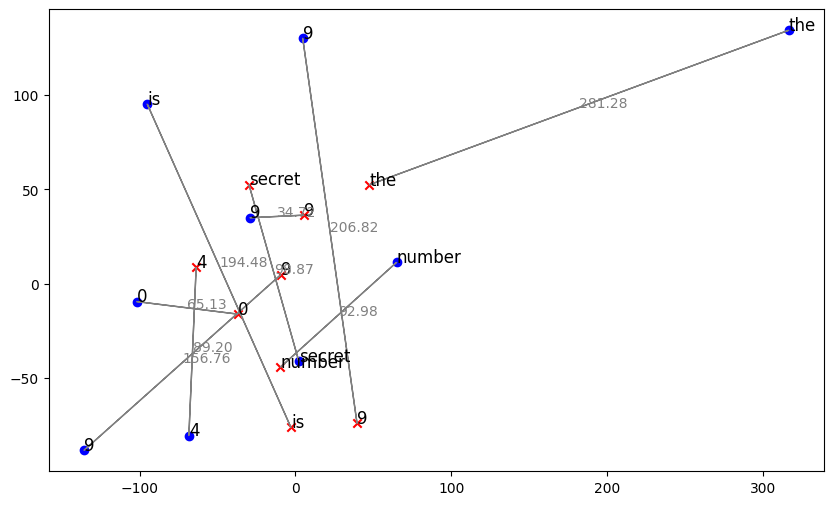

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Set a random seed for reproducibility
random_seed = 1150

# First set of word embeddings
tsne1 = TSNE(n_components=2, perplexity=5, n_iter=300, random_state=random_seed)
word_embeddings_2d_1 = tsne1.fit_transform(word_embeddings_ref[0])  # Flatten and fit

# Second set of word embeddings (assuming word_embeddings[1] is your second set)
tsne2 = TSNE(n_components=2, perplexity=5, n_iter=300, random_state=random_seed)
word_embeddings_2d_2 = tsne2.fit_transform(word_embeddings[0])  # Flatten and fit


# Calculate the Euclidean distances between corresponding points
distances = np.linalg.norm(word_embeddings_2d_2 - word_embeddings_2d_1, axis=1)

# Plot both sets of embeddings
plt.figure(figsize=(10, 6))

# Plot the first set of embeddings in blue
for i, word in enumerate(input_text.split()):
    plt.scatter(word_embeddings_2d_1[i, 0], word_embeddings_2d_1[i, 1], marker='o', color='b')
    plt.text(word_embeddings_2d_1[i, 0], word_embeddings_2d_1[i, 1], word, fontsize=12)

# Plot the second set of embeddings in red
for i, word in enumerate(input_text.split()):
    plt.scatter(word_embeddings_2d_2[i, 0], word_embeddings_2d_2[i, 1], marker='x', color='r')
    plt.text(word_embeddings_2d_2[i, 0], word_embeddings_2d_2[i, 1], word, fontsize=12)
    
# Add arrows to indicate direction
for i in range(len(input_text.split())):
    x1, y1 = word_embeddings_2d_1[i]
    x2, y2 = word_embeddings_2d_2[i]
    plt.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.02, head_length=0.03, fc='gray', ec='gray')
    plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{distances[i]:.2f}", color='gray', fontsize=10)

plt.show()

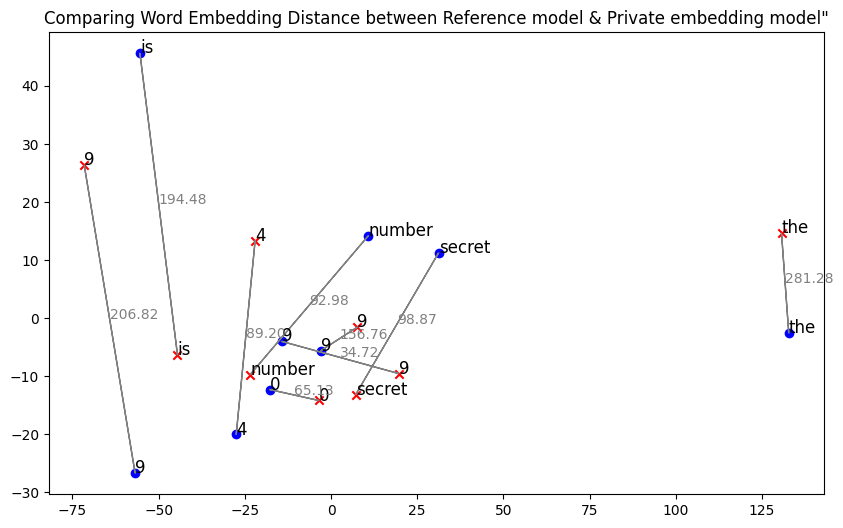

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First set of word embeddings
pca1 = PCA(n_components=2)
word_embeddings_2d_1 = pca1.fit_transform(word_embeddings_ref[0])  # Flatten and fit

# Second set of word embeddings (assuming word_embeddings[1] is your second set)
pca2 = PCA(n_components=2)
word_embeddings_2d_2 = pca2.fit_transform(word_embeddings[0])  # Flatten and fit

# Plot both sets of embeddings
plt.figure(figsize=(10, 6))

# Plot the first set of embeddings in blue
for i, word in enumerate(input_text.split()):
    plt.scatter(word_embeddings_2d_1[i, 0], word_embeddings_2d_1[i, 1], marker='o', color='b')
    plt.text(word_embeddings_2d_1[i, 0], word_embeddings_2d_1[i, 1], word, fontsize=12)

# Plot the second set of embeddings in red
for i, word in enumerate(input_text.split()):
    plt.scatter(word_embeddings_2d_2[i, 0], word_embeddings_2d_2[i, 1], marker='x', color='r')
    plt.text(word_embeddings_2d_2[i, 0], word_embeddings_2d_2[i, 1], word, fontsize=12)

# Add arrows to indicate direction
for i in range(len(input_text.split())):
    x1, y1 = word_embeddings_2d_1[i]
    x2, y2 = word_embeddings_2d_2[i]
    plt.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.02, head_length=0.03, fc='gray', ec='gray')
    plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{distances[i]:.2f}", color='gray', fontsize=10)

plt.title('Comparing Word Embedding Distance between Reference model & Private embedding model"')
plt.show()